In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection
from scipy.spatial.distance import squareform, pdist, cdist, cosine
from scipy.stats import zscore, ttest_ind, ttest_rel
import scipy.integrate as spint

if not hasattr(spint, 'simps'):
    spint.simps = spint.simpson
    
from sklearn_extra.cluster import KMedoids
from itertools import groupby

import nibabel as nib
from nilearn.image import resample_img, resample_to_img
from nilearn.plotting import plot_stat_map

from nctpy.energies import get_control_inputs, integrate_u
from nctpy.utils import normalize_state, matrix_normalization

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
from matplotlib.patches import RegularPolygon
from matplotlib.transforms import Affine2D
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine

import seaborn as sns

In [2]:
def r2(x,y):
    return(cdist(np.array([x]), np.array([y]),'correlation')[0][0])

def medoid_silhouette(diss, ind):
    medoid_silhouette_values = np.zeros(diss.shape[0])
    for ind1 in range(diss.shape[0]):
        silh  = sorted([diss[ind1, ind2] for ind2 in ind])
        num = silh[0]#closest cluster center
        if silh[1] == 0:
            medoid_silhouette_values[ind1] = 1
        else:
            medoid_silhouette_values[ind1] = 1-num/silh[1]
    return(medoid_silhouette_values)

def silhouette_plot(values, clusters, K, it, ax):
    y_lower = 10
    for k in range(K):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = values[K,it][clusters[K,it] == k]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(k) / K)
        ax.fill_betweenx(np.arange(y_lower, y_upper),0,ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(k))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    # The vertical line for average silhouette score of all the values
    ax.set_title('Silhouette Plot', fontsize = 16)
    ax.set_xlabel('Silhouette Coefficient Values', fontsize = 14)
    ax.set_ylabel('Cluster label', fontsize = 14)
    ax.axvline(x=values[K,it].mean(), color="black", linestyle="--", label = 'Mean')
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.legend()

def fractional_occs(labels, K):#calculate fractional occupancy for a given subject's state sequence and number of clusters
    uniq, cts = np.unique(labels, return_counts=True)
    frq = np.zeros(K)
    for _, k in enumerate(uniq):
        frq[k] = cts[_]/len(labels)#percentage
    return(frq)

def dwell_times(labels, K, t_r, thresh = 1): 
    #calculate dwell times for a given subject's state sequence and number of clusters. thresh variable adjusts how many repetitions counts as dwelling i.e., if thresh ==1, at least 2 consecutive repetitions counts as dwelling
    count_dups = [(_,sum(1 for _ in group)) for _, group in groupby(labels)]
    dwell_t = [[] for _ in range(K)]
    for st, ct in count_dups:
        if ct > thresh:
            dwell_t[st].append(ct)
    dwelltime = []
    for dwell in dwell_t:
        if dwell:
            dwelltime.append(np.mean(dwell) * t_r)
        else:
            dwelltime.append(0 * t_r)
    return(dwelltime)


def get_yeo_networks(states, yeo8, resampled_aparcaseg, size, K):
    all_cos = []
    for k in range(K):
        yeo_array = yeo8.get_fdata()
        aparc_array = resampled_aparcaseg.get_fdata()

        cos_sim = []
        for y in range(1,len(np.unique(yeo_array))):
            yeo_networkx = np.where(yeo_array == y)
            aparc_network = aparc_array[yeo_networkx]
            
            uniq,cts = np.unique(aparc_network[np.nonzero(aparc_network)], return_counts=True)
            roi_counts = {int(roi): count for roi, count in zip(uniq, cts)}
            yeo_vector = np.zeros(size)
            for i,roi in enumerate(np.unique(aparc_array)[1:]): #ignore 0
                if int(roi) in roi_counts:
                    total_roi = np.sum(aparc_array == int(roi))
                    yeo_vector[i] = roi_counts[int(roi)]/total_roi if total_roi > 0 else 0
            cos_sim.append(float(1-cosine(yeo_vector,states[k])))
        all_cos.append(cos_sim)
    return(all_cos)


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels, fs):
            self.set_thetagrids(np.degrees(theta), labels, fontsize = fs)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars, radius=0.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.

                
                spine.set_transform(Affine2D().scale(0.5).translate(.5, .5)+ self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


# Function to generate a single random adjacency matrix
def random_adjacency(n):
    mat = np.random.rand(n, n)           # random values [0,1)
    mat = (mat + mat.T)/2                # make symmetric
    np.fill_diagonal(mat, 0)             # set diagonal to 0
    return mat

def NCT_multi(healthyID, mddID, DTI_matrix, states, K, size, time_h = 1, rho = 1, system = 'continuous'):
    
    s_trajectories = {idx:np.zeros((K,K,1001,size)) for idx in healthyID+mddID}
    c_signals= {idx:np.zeros((K,K,1001,size)) for idx in healthyID+mddID}
    n_energies = {idx:np.zeros((K,K,size)) for idx in healthyID+mddID}
    t_energies = {idx:np.zeros((K,K)) for idx in healthyID+mddID}
    
    s_trajectories_pers = {idx:np.zeros((K,K,1001,size)) for idx in healthyID+mddID}
    c_signals_pers = {idx:np.zeros((K,K,1001,size)) for idx in healthyID+mddID}
    n_energies_pers = {idx:np.zeros((K,K,size)) for idx in healthyID+mddID}
    t_energies_pers = {idx:np.zeros((K,K)) for idx in healthyID+mddID}
    
    control_s, trajectory_c = np.eye(size), np.eye(size)
    # normalize structural connectivity
    for idx in healthyID+mddID:
        norm_adjs_struct = matrix_normalization(A=DTI_matrix[idx], system=system, c=1)
        for k1 in range(K):
            for k2 in range(K):
                if k1 != k2:
                    #get the state trajectory, x(t), and the control signals, u(t)
                    s_trajectories[idx][k2,k1], c_signals[idx][k2,k1], numerical_errors = get_control_inputs(A_norm = norm_adjs_struct, T = time_h, B = control_s, x0 = states[k1], xf = states[k2], system = system, rho = rho, S = trajectory_c)
                    # print errors
                    thr = 1e-8
                    if (numerical_errors[0] >= thr) or (numerical_errors[1] >= thr):
                        # the first numerical error corresponds to the inversion error # the second numerical error corresponds to the reconstruction error
                        print("Subject: %s, Transition: %dto%d"%(idx,k1,k2), 
                        "Inversion error = {:.2E} (<{:.2E}={:})".format(numerical_errors[0], thr, numerical_errors[0] < thr), 
                        "Reconstruction error = {:.2E} (<{:.2E}={:})".format(numerical_errors[1], thr, numerical_errors[1] < thr))
                        
                    # integrate control signals to get control energy
                    n_energies[idx][k2,k1] = integrate_u(c_signals[idx][k2,k1])
                    t_energies[idx][k2,k1] = np.sum(n_energies[idx][k2,k1]) ##from state k1 to k2
                else:#get persistence energies in a seperate array
                    #get the state trajectory, x(t), and the control signals, u(t)
                    s_trajectories_pers[idx][k2,k1], c_signals_pers[idx][k2,k1], numerical_errors = get_control_inputs(A_norm = norm_adjs_struct, T = time_h, B = control_s, x0 = states[k1], xf = states[k2], system = system, rho = rho, S = trajectory_c)
                    # print errors
                    thr = 1e-8
                    if (numerical_errors[0] >= thr) or (numerical_errors[1] >= thr):
                        # the first numerical error corresponds to the inversion error # the second numerical error corresponds to the reconstruction error
                        print("Subject: %s, Transition: %dto%d"%(idx,k1,k2), 
                        "Inversion error = {:.2E} (<{:.2E}={:})".format(numerical_errors[0], thr, numerical_errors[0] < thr), 
                        "Reconstruction error = {:.2E} (<{:.2E}={:})".format(numerical_errors[1], thr, numerical_errors[1] < thr))
                        
                    # integrate control signals to get control energy
                    n_energies_pers[idx][k2,k1] = integrate_u(c_signals_pers[idx][k2,k1])
                    t_energies_pers[idx][k2,k1] = np.sum(n_energies_pers[idx][k2,k1]) ##from state k1 to k2

    return(t_energies, n_energies, s_trajectories, c_signals, t_energies_pers, n_energies_pers, s_trajectories_pers, c_signals_pers)

In [3]:
working_path = '/Users/ulgenklc/Library/CloudStorage/OneDrive-TheMountSinaiHospital/kilicb01/Papers/K01_VTA/paper_K01_VTA/code/'#add your path

In [4]:
# Parameters
size = 85          # number of regions
duration = 200     # time points per subject
n_subjects = 20    # total subjects
n_healthy = n_subjects // 2
n_mdd = n_subjects // 2

# Simulate data as dicts: each subject -> size x duration matrix
np.random.seed(42)  # for reproducibility
healthyFMRI = {str(500+i): np.random.randn(size, duration) for i in range(n_healthy)}
mddFMRI = {str(600+i): np.random.randn(size, duration) for i in range(n_mdd)}

# Get IDs
healthyID = list(healthyFMRI.keys())
mddID = list(mddFMRI.keys())

# Preallocate arrays
X_hcz1 = np.zeros((size, sum([healthyFMRI[idx].shape[1] for idx in healthyID])))
X_mddz1 = np.zeros((size, sum([mddFMRI[idx].shape[1] for idx in mddID])))

# Fill in healthy
dur = 0
for idx in healthyID:
    mat = zscore(healthyFMRI[idx], axis=1, nan_policy='raise')
    X_hcz1[:, dur:dur + mat.shape[1]] = mat
    dur += mat.shape[1]

# Fill in mdd
dur = 0
for idx in mddID:
    mat = zscore(mddFMRI[idx], axis=1, nan_policy='raise')
    X_mddz1[:, dur:dur + mat.shape[1]] = mat
    dur += mat.shape[1]

# Concatenate
X_prez1 = np.concatenate((X_hcz1, X_mddz1), axis=1)
X_prez1[np.isnan(X_prez1)] = 0

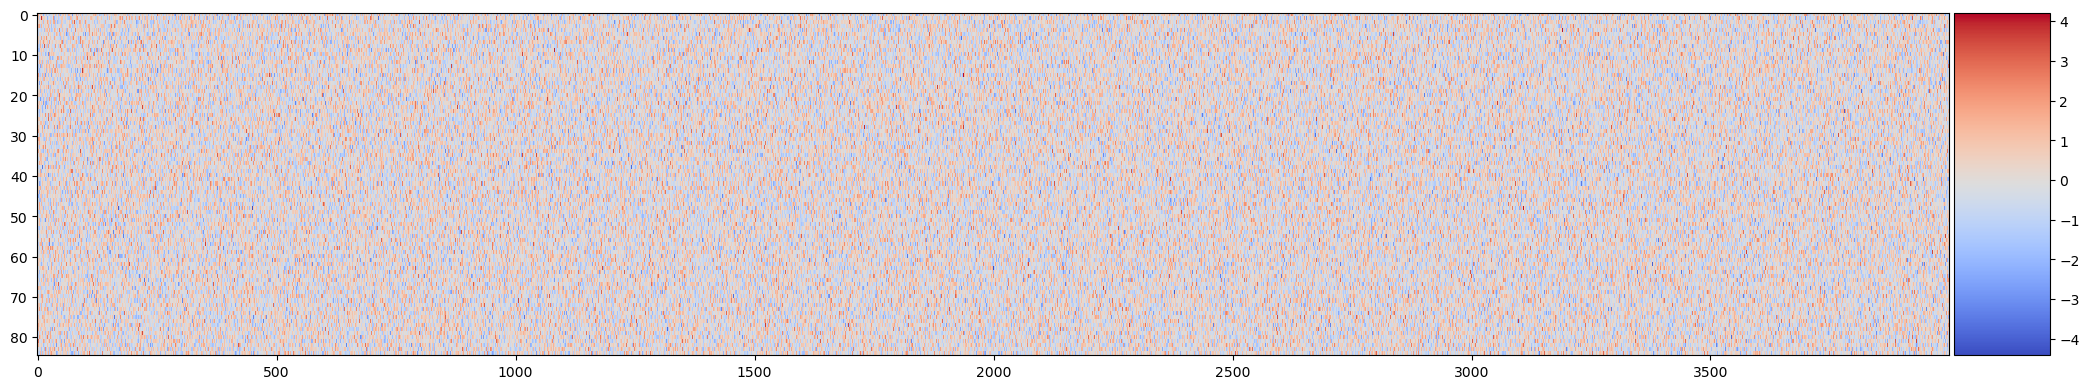

In [5]:
#Display point cloud
fig, ax = plt.subplots(1,1,figsize = (21,4))
im = ax.imshow(X_prez1, aspect = 'auto', interpolation = 'none', cmap = 'coolwarm')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax)
plt.tight_layout()

In [6]:
# Define range of cluster numbers to test (K = 2 to 17)
Ks = np.arange(2, 10)

# Number of iterations (repeated clustering runs for stability analysis)
niter = 10

clusters, indices, inertias = {}, {}, {}

# Compute the pairwise dissimilarity matrix between all time points
#   - X_prez1.T: shape (n_timepoints, n_regions)
#   - 'correlation' metric → distance = 1 - correlation coefficient
#   - squareform: convert condensed distance vector into a square matrix
diss = squareform(pdist(X_prez1.T, metric='correlation'))

# Run clustering multiple times for each K
for it in range(niter):
    for K in Ks:
        # Initialize and fit K-Medoids clustering with:
        #   - precomputed distance matrix
        #   - 'k-medoids++' initialization
        #   - 'alternate' approximation method which is fast or 'pam' method which is more robust but much slower
        km = KMedoids(init="k-medoids++",n_clusters=K,metric='precomputed',method='alternate').fit(diss)

        # Store the results for this iteration and K
        clusters[K, it] = km.labels_  
        indices[K, it] = km.medoid_indices_ 
        inertias[K, it] = km.inertia_    

# Dictionary to store the actual medoid time series
medoids = {}
for it in range(niter):
    for _, K in enumerate(Ks):
        # Extract medoid time series from X_prez1.T using saved medoid indices
        medoids[K, it] = X_prez1.T[indices[K, it]]

In [7]:
bt_vr,wt_vr = {},{}
for it in range(niter):
    between_var, within_var = [], []
    for K in Ks:
        btw_var, wtn_var = [], []
        for k1 in range(K):
            #calculate BETWEEN cluster variance for each k
            var = [r2(medoids[K,it][k2], medoids[K,it][k1]) for k2 in range(K)]
            btw_var.append(np.array(var).mean())
    
            #calculate WITHIN cluster variance for each k
            var = [r2(X_prez1.T[tr_label], medoids[K,it][k1]) for tr_label in np.where(clusters[K,it] == k1)[0]]
            wtn_var.append(np.array(var).mean())
            
        between_var.append(np.array(btw_var).mean())
        within_var.append(np.array(wtn_var).mean())
        
    bt_vr[it] = between_var
    wt_vr[it] = within_var
    
#calculate medoid sihouette coefficients
medoids_silhouette1_values = {}
diss = squareform(pdist(X_prez1.T, metric = 'correlation'))
for it in range(niter):
    for K in Ks:
        medoids_silhouette1_values[K,it] = medoid_silhouette(diss, indices[K,it])

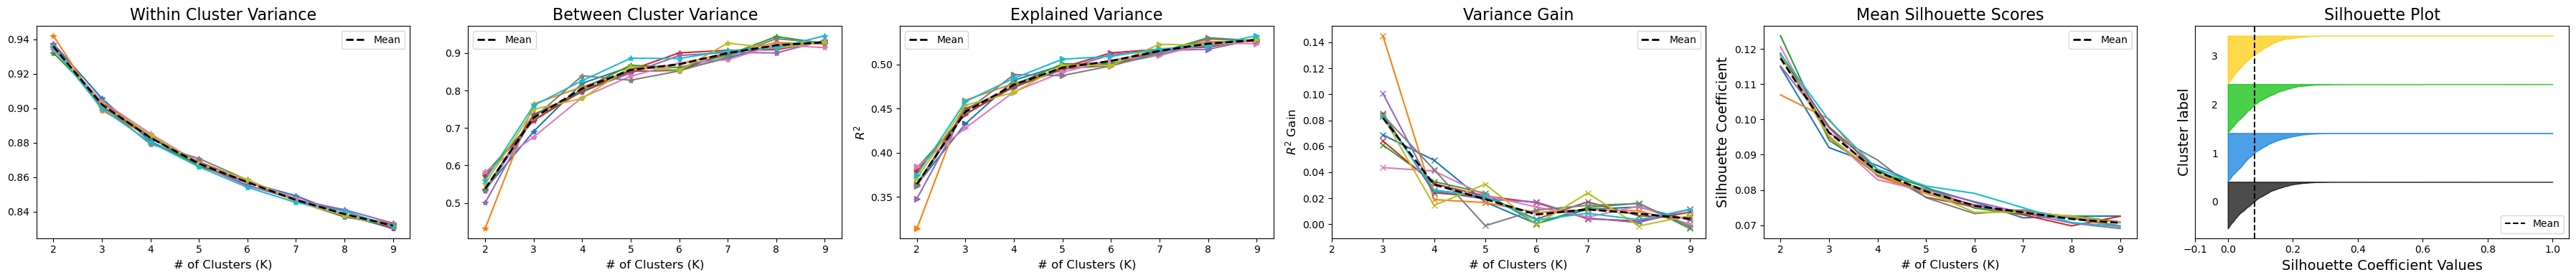

In [8]:
explained_var, var_gain = {}, {}

fig,ax = plt.subplots(1,6, figsize = (36,4))
for it in range(niter):
    ax[0].plot(Ks, wt_vr[it], marker = '*')
    ax[1].plot(Ks, bt_vr[it], marker = '*')
    
    explained_var[it] = bt_vr[it]/(np.array(bt_vr[it])+np.array(wt_vr[it]))
    ax[2].plot(Ks, explained_var[it], marker = '>')

    var_gain[it] = np.diff(bt_vr[it]/(np.array(bt_vr[it])+np.array(wt_vr[it])))
    ax[3].plot(Ks[1:], var_gain[it],  marker = 'x')

    ax[4].plot(Ks,[medoids_silhouette1_values[K,it].mean() for K in Ks])
    
ax[0].plot(Ks, np.array(list(wt_vr.values())).mean(axis = 0), c = 'black', lw = 2, ls = '--', label = 'Mean')
ax[1].plot(Ks, np.array(list(bt_vr.values())).mean(axis = 0), c = 'black', lw = 2, ls = '--', label = 'Mean')
ax[2].plot(Ks, np.array(list(explained_var.values())).mean(axis = 0), c = 'black', lw = 2, ls = '--', label = 'Mean')
ax[3].plot(Ks[1:],np.array(list(var_gain.values())).mean(axis = 0), c = 'black', lw = 2, ls = '--', label = 'Mean')
ax[4].plot(Ks,np.array([[medoids_silhouette1_values[K,it].mean() for K in Ks] for it in range(niter)]).mean(axis = 0), c = 'black', lw = 2, ls = '--', label = 'Mean')

K=4
it = np.argmax([inertias[K,it] for it in range(niter)])
silhouette_plot(medoids_silhouette1_values, clusters, K, it, ax[5])

for i in range(5):
    ax[i].set_xticks(Ks)
    ax[i].legend()
    ax[i].set_xlabel('# of Clusters (K)', fontsize = 12)



ax[0].set_title('Within Cluster Variance', fontsize = 16)
ax[1].set_title('Between Cluster Variance', fontsize = 16)
ax[2].set_title('Explained Variance', fontsize = 16)
ax[3].set_title('Variance Gain', fontsize = 16) # variance gain from increasing from k-1 to k
ax[4].set_title('Mean Silhouette Scores', fontsize = 16)

ax[2].set_ylabel(r'$R^{2}$', fontsize = 12)
ax[3].set_ylabel(r'$R^{2}$ Gain', fontsize = 12)
ax[4].set_ylabel('Silhouette Coefficient', fontsize = 14)

plt.tight_layout()

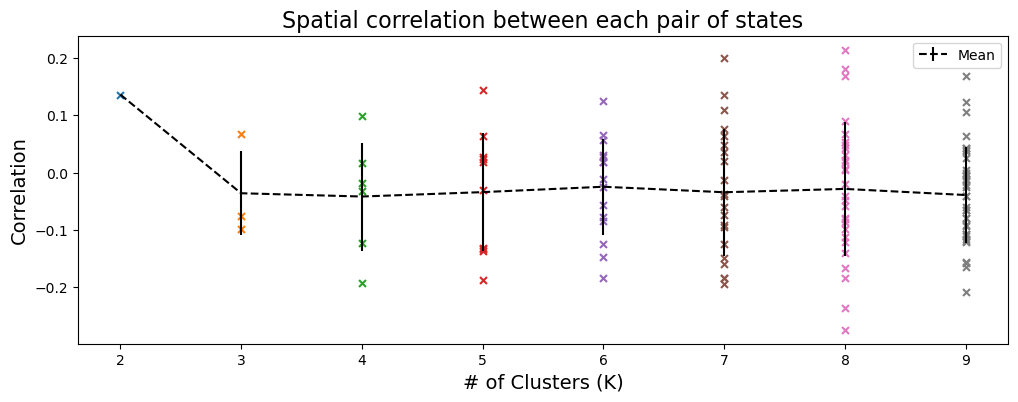

In [9]:
spatial_corr_matrices = {}
fig,ax = plt.subplots(1,1,figsize = (12,4))
for _K, K in enumerate(Ks):
    it = np.argmax([inertias[K,it] for it in range(niter)])
    spatial_corr_matrices[K] = 1-squareform(pdist(medoids[K,it],metric='correlation'))
    upper = np.triu(spatial_corr_matrices[K],1)
    upper[np.nonzero(upper)]
    ax.scatter([K]*len(upper[np.nonzero(upper)]),upper[np.nonzero(upper)], s = 25, marker = 'x')
ax.set_xlabel('# of Clusters (K)', fontsize = 14)
ax.set_ylabel('Correlation', fontsize = 14)
ax.set_title('Spatial correlation between each pair of states', fontsize = 16)
ax.errorbar(Ks, [(np.triu(spatial_corr_matrices[K],1)[np.nonzero(np.triu(spatial_corr_matrices[K],1))]).mean() for K in Ks], [(np.triu(spatial_corr_matrices[K],1)[np.nonzero(np.triu(spatial_corr_matrices[K],1))]).std() for K in Ks], c = 'black', lw = 1.5,ls = 'dashed', label = 'Mean')

ax.set_xticks(Ks)
ax.legend()

In [10]:
state_fraq_occ,  dwellTIME= {}, {}

tr = 2 # repetition time in seconds

for K in Ks:
    it = np.argmax([inertias[K,it] for it in range(niter)])
    dur = 0
    for i, idx in enumerate(healthyID+mddID):
        if idx in healthyID:
            size, duration = healthyFMRI[idx].shape
        else:
            size, duration = mddFMRI[idx].shape
        subj_labels = clusters[K,it][dur:dur+duration]
        dur = dur + duration

        #calculate fractional occupancy and dwell times
        frq = fractional_occs(subj_labels, K)
        dwell_time = dwell_times(subj_labels, K, tr)
            
        state_fraq_occ[idx,K] = frq*100 ##percentage
        dwellTIME[idx,K] = dwell_time #seconds

In [11]:
#import randomly generated clinical scores
clinical = pd.read_csv(working_path+'Clinical_Scores.csv')
clinical_measures = ['QIDS', 'MASQ_AA', 'MASQ_AD', 'MASQ_GD', 'RRS_DR', 'RRS_BR', 'RRS_RF']

SEX = {idx:0 if (clinical[clinical.study_ID == int(idx)].SUB_gender.iloc[0] == "F") else 1 for idx in healthyID+mddID}
AGE = {idx:clinical[clinical.study_ID == int(idx)]['SUB_Age '].iloc[0] for idx in healthyID+mddID}
MEDS = {idx:0 if (clinical[clinical.study_ID == int(idx)].Medication.iloc[0] == 'no') else 1 for idx in healthyID+mddID}

QIDS = {idx:clinical[clinical.study_ID == int(idx)].QIDS_score.iloc[0] for idx in healthyID+mddID}

MASQ_aa = {idx:clinical[clinical.study_ID == int(idx)].MASQ_aa_score.iloc[0] for idx in healthyID+mddID}
MASQ_ad = {idx:clinical[clinical.study_ID == int(idx)].MASQ_ad_score.iloc[0]  for idx in healthyID+mddID}
MASQ_gd = {idx: clinical[clinical.study_ID == int(idx)].MASQ_gd_score.iloc[0] for idx in healthyID+mddID}

RRS_dr = {idx:clinical[clinical.study_ID == int(idx)].RRS_Depression_Related.iloc[0]  for idx in healthyID+mddID}
RRS_b = {idx: clinical[clinical.study_ID == int(idx)].RRS_Brooding.iloc[0] for idx in healthyID+mddID}
RRS_r = {idx: clinical[clinical.study_ID == int(idx)].RRS_Reflection.iloc[0] for idx in healthyID+mddID}

In [12]:
totst_, KS_, ids_, type_, sex_, age_, meds_ = [], [], [], [], [], [], []
dwellt_,  fraqoc_  = [], []
qids_, masqaa_, masqad_, masqgd_, rrsdr_, rrsb_, rrsr_  = [], [], [], [], [], [], []
for i, idx in enumerate(healthyID+mddID):
    if idx in healthyID:
        typ = 'HC'
    else:
        typ = 'MDD'
    for K in Ks:
        for k in range(K):
            totst_.append(K)
            KS_.append(k)
            ids_.append(idx)
            type_.append(typ)
            sex_.append(SEX[idx])
            age_.append(AGE[idx])
            meds_.append(MEDS[idx])
            
            dwellt_.append(dwellTIME[idx,K][k])
            fraqoc_.append(state_fraq_occ[idx,K][k])

            qids_.append(QIDS[idx])
            
            masqaa_.append(MASQ_aa[idx])
            masqad_.append(MASQ_ad[idx])
            masqgd_.append(MASQ_gd[idx])

            rrsdr_.append(RRS_dr[idx])
            rrsb_.append(RRS_b[idx])
            rrsr_.append(RRS_r[idx])
            
df = pd.DataFrame({'SubjectID':ids_, 'Morbidity':type_, 'Sex':sex_, 'Age':age_, 'Medication':meds_, 'totalstates':totst_, 'StateID':KS_, 
                   'DWELLTIME':dwellt_, 'FRAQOCC':fraqoc_,
                   'QIDS':qids_, 'MASQ_AA':masqaa_, 'MASQ_AD':masqad_, 'MASQ_GD':masqgd_,  'RRS_DR':rrsdr_, 'RRS_BR':rrsb_, 'RRS_RF':rrsr_})

K = 4
Dwell TIME: ['t:0.873, p:0.394', 't:0.033, p:0.974', 't:0.782, p:0.445', 't:0.398, p:0.695'] 
-----------------------------------


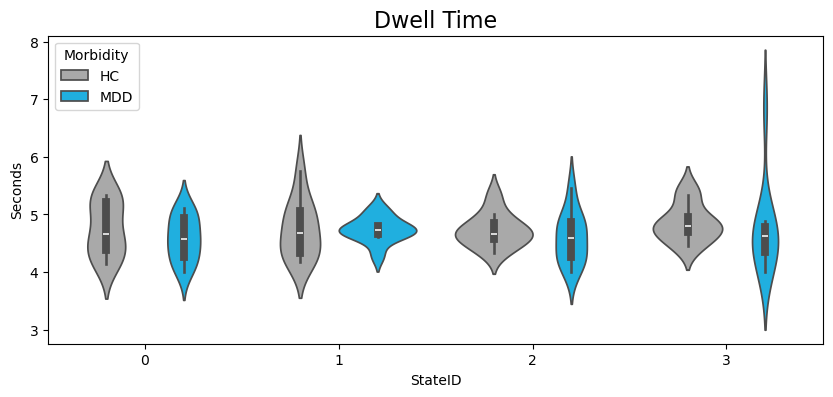

In [13]:
K = 4
it  = np.argmax([inertias[K,it] for it in range(niter)])
my_pal = {"HC": "darkgrey", "MDD": "deepskyblue"}

fig, ax = plt.subplots(1,1, figsize = (10,4))
sns.violinplot(data = df[df.totalstates == K], x = 'StateID', y = 'DWELLTIME', hue = 'Morbidity', ax = ax, palette=my_pal)
ax.set_title('Dwell Time', fontsize = 16)
ax.set_ylabel('Seconds')
dwell_p = ['t:%.3f, p:%.3f'%(ttest_ind(df[(df.Morbidity == 'HC')&(df.StateID == k)&(df.totalstates == K)].DWELLTIME.to_numpy(),df[(df.Morbidity == 'MDD')&(df.StateID == k)&(df.totalstates == K)].DWELLTIME.to_numpy())) for k in range(K)]
print('K = %d'%K)
print('Dwell TIME:', dwell_p, f'\n'
'-----------------------------------')

K = 4
Frac Occupancy: ['t:-1.585, p:0.135', 't:-0.271, p:0.790', 't:0.060, p:0.953', 't:2.308, p:0.033'] 
-----------------------------------


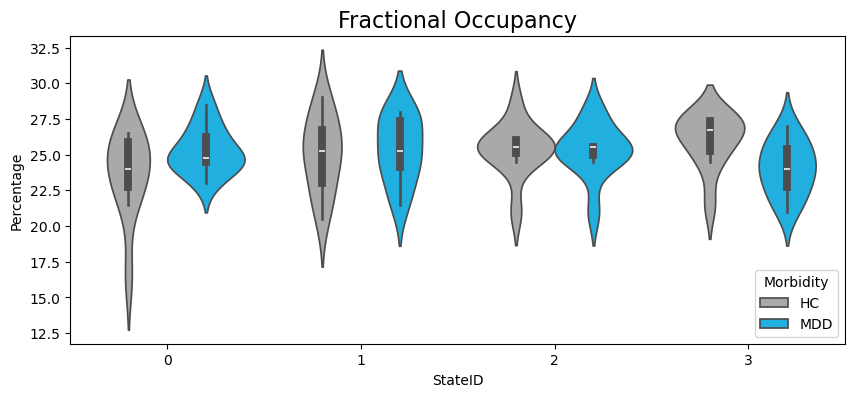

In [14]:
K = 4
it  = np.argmax([inertias[K,it] for it in range(niter)])

my_pal = {"HC": "darkgrey", "MDD": "deepskyblue"}
 
fig, ax = plt.subplots(1,1, figsize = (10,4))
sns.violinplot(data = df[df.totalstates == K], x = 'StateID', y = 'FRAQOCC', hue = 'Morbidity', ax = ax, palette=my_pal)
ax.set_title('Fractional Occupancy', fontsize = 16)
ax.set_ylabel('Percentage')

frac_p = ['t:%.3f, p:%.3f'%(ttest_ind(df[(df.Morbidity == 'HC')&(df.StateID == k)&(df.totalstates == K)].FRAQOCC.to_numpy(),df[(df.Morbidity == 'MDD')&(df.StateID == k)&(df.totalstates == K)].FRAQOCC.to_numpy(), equal_var=False)) for k in range(K)]
print('K = %d'%K)
print('Frac Occupancy:', frac_p, f'\n'
          '-----------------------------------')

In [15]:
K = 4
it  = np.argmax([inertias[K,it] for it in range(niter)])

brain = nib.load(working_path + 'brain_templates/sub-001_ses-1_brain.nii.gz')
aparcaseg = nib.load(working_path + 'brain_templates/sub-001_ses-1_atlas-L2018_res-scale1_dseg.nii.gz')
yeo7 = nib.load(working_path + 'brain_templates/Yeo7_Network_sub-001.nii.gz')

Text(0.5, 1.0, 'Native brain parcellation (Yeo7+Subcortical, N = 8)')

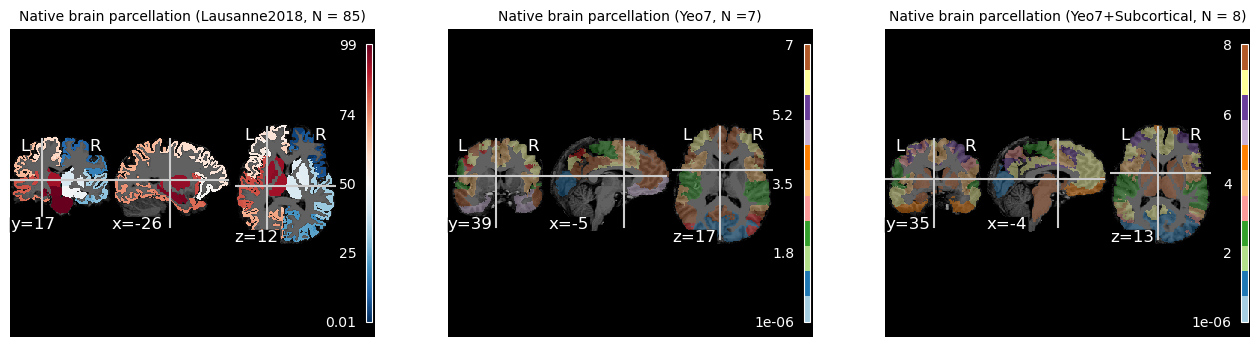

In [16]:
K = 4
it  = np.argmax([inertias[K,it] for it in range(niter)])

fig,ax = plt.subplots(1,3,figsize = (16,4))

resampled_aparcaseg = resample_img(aparcaseg, target_affine=brain.affine, target_shape = brain.shape, interpolation='nearest', force_resample=True, copy_header=True)
plot_stat_map(resampled_aparcaseg, threshold = 0.01, bg_img=brain, axes = ax[0])
ax[0].set_title('Native brain parcellation (Lausanne2018, N = 85)', fontsize = 10)

resampled_yeo7 = resample_img(yeo7, target_affine=brain.affine, target_shape = brain.shape, interpolation='nearest', force_resample=True, copy_header=True)
plot_stat_map(resampled_yeo7, cmap = 'Paired', axes = ax[1], bg_img = brain, transparency = 0.4)
ax[1].set_title('Native brain parcellation (Yeo7, N =7)', fontsize = 10)

subcortical_inds = ['42', '43', '44', '45', '46', '47', '48', '49', '91', '92', '93','94', '95', '96', '97', '98', '99']#indices of subcortical regions in aparcaseg
subcortical_args = [np.where(resampled_aparcaseg.get_fdata()==int(si)) for si in subcortical_inds]
    
yeo_array = resampled_yeo7.get_fdata().copy()
for i, si in enumerate(subcortical_inds):
    yeo_array[subcortical_args[i]] = 8 ##subcortical index
yeo8 = resample_to_img(nib.Nifti1Image(yeo_array, affine = resampled_yeo7.affine), brain, force_resample=True, copy_header=True)
plot_stat_map(yeo8, cmap = 'Paired', axes = ax[2], bg_img = brain, transparency = 0.4)
ax[2].set_title('Native brain parcellation (Yeo7+Subcortical, N = 8)', fontsize = 10)

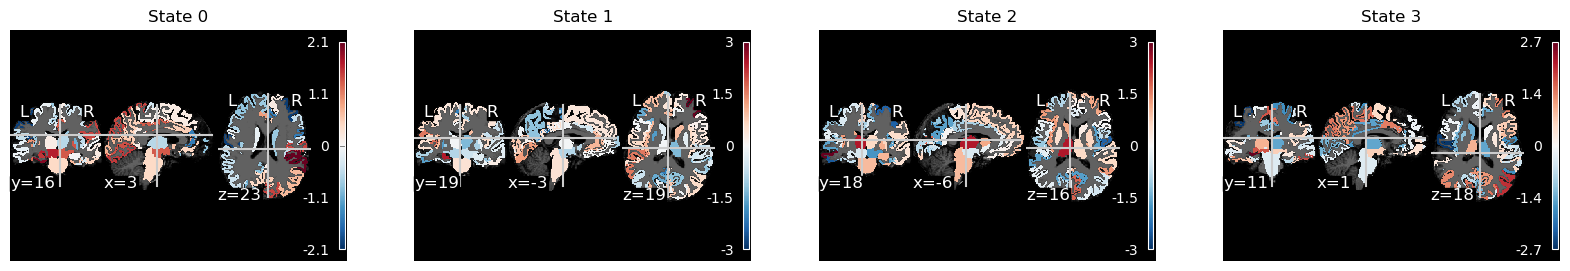

In [17]:
K = 4
it  = np.argmax([inertias[K,it] for it in range(niter)])

fig,ax = plt.subplots(1,K,figsize = (20,3))
for k in range(K):
    aparcaseg_data = resampled_aparcaseg.get_fdata()
    state_mask = np.zeros((aparcaseg_data.shape))
    for i, roi in enumerate(np.unique(aparcaseg_data)[1:]):
        state_mask[np.where(aparcaseg_data == roi)] = medoids[K,it][k][i]
    
    # Update the affine matrix to Scanner RAS
    img = nib.Nifti1Image(state_mask, affine = resampled_aparcaseg.affine)
    plot_stat_map(img, threshold = 0.01, bg_img = brain, axes=  ax[k])
    ax[k].set_title('State %s'%k, fontsize = 12)

In [18]:
K = 4
it  = np.argmax([inertias[K,it] for it in range(niter)])

#1)High amplitude states i.e. positive z-score
#2)Low amplitude states i.e. negative z-score

medoid1 = medoids[K,it].copy()
medoid1[medoid1 <= 0] = 0
pos_amplitude = medoid1.copy()
    
medoid2 = medoids[K,it].copy()
medoid2[medoid2 > 0] = 0
neg_amplitude = abs(medoid2.copy())


all_data8 = {}
#map negative and positive compnents of  the activity to radars
yeo8_pos = get_yeo_networks(pos_amplitude, yeo8, resampled_aparcaseg, size, K)
yeo8_neg = get_yeo_networks(neg_amplitude, yeo8, resampled_aparcaseg, size, K)

for k in range(K):
    all_data8[k] = [yeo8_pos[k], yeo8_neg[k]]

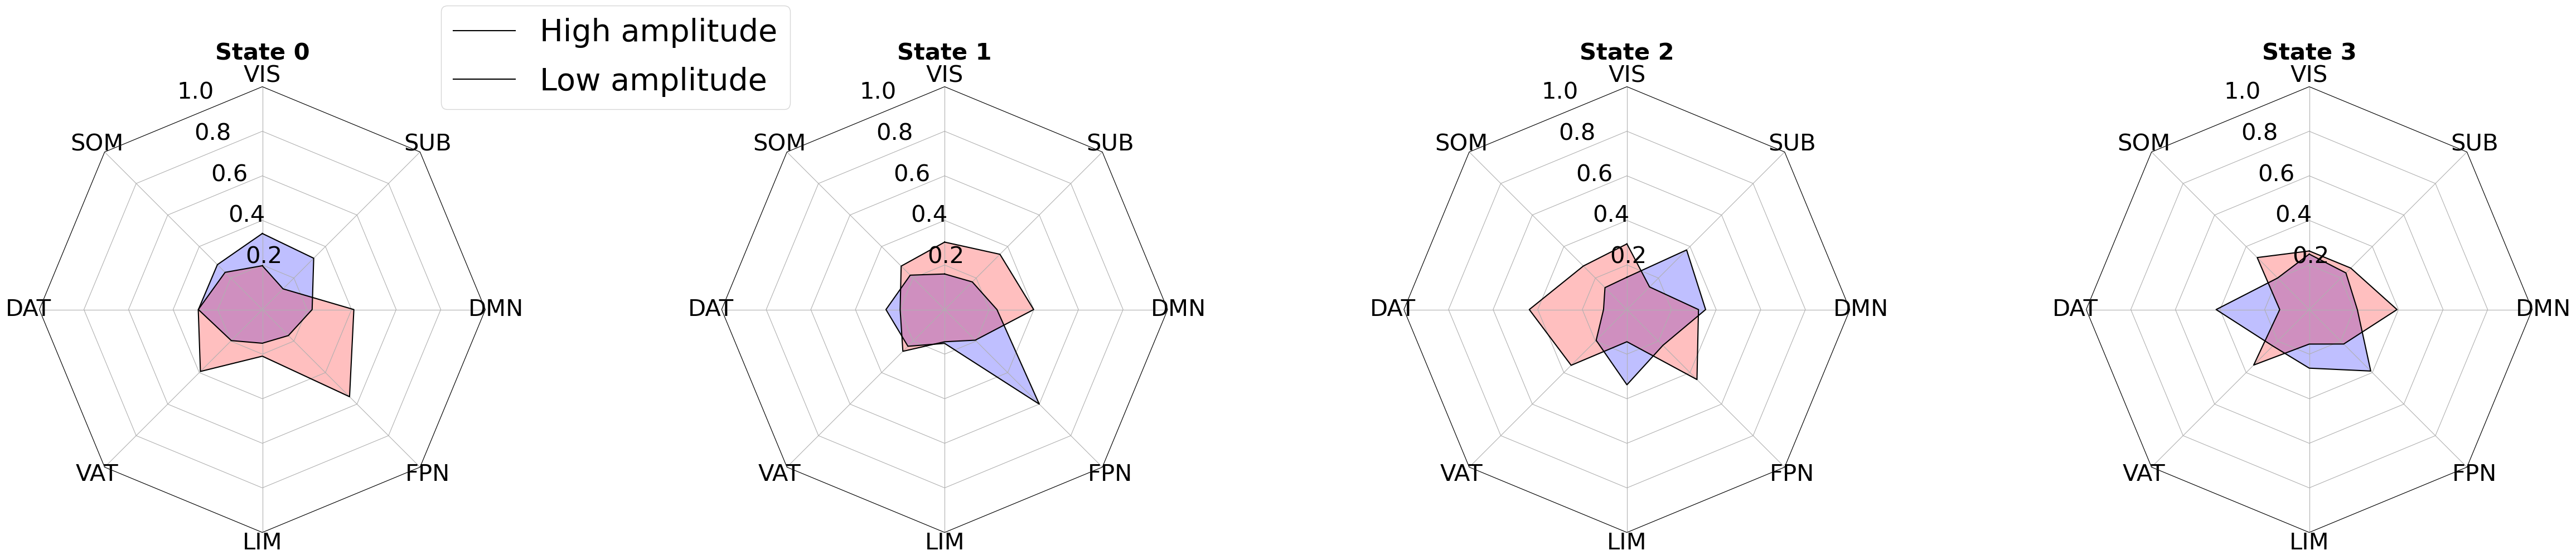

In [19]:
yeo7rois = pd.read_csv(working_path + 'brain_templates/Yeo_JNeurophysiol11_MNI152/7NetworksOrderedNames.csv')
yeo7rois.loc[len(yeo7rois)] =[8,'SUB']

theta = radar_factory(8, frame = 'polygon')

fig, ax = plt.subplots(figsize=(60, 10), nrows=1, ncols=K,subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r']
# Plot the four cases from the example data on separate Axes
for k in range(K):
    ax[k].set_rgrids([0.2, 0.4, 0.6, 0.8,1], fontsize = 30)
    ax[k].set_ylim(0, 1)
    for d, color in zip(all_data8[k], colors):
        ax[k].plot(theta, d, color='black')
        ax[k].fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax[k].set_varlabels(yeo7rois[' Network Name'].to_list(), 30)
    ax[k].set_title('State %d'%k, weight='bold', fontsize = 30, position=(0.5, 1.1), horizontalalignment='center', verticalalignment='center')

# add legend relative to top-left plot
labels = ('High amplitude', 'Low amplitude')
legend = ax[0].legend(labels, loc=(0.9, .95),labelspacing=0.6, fontsize=40)

In [20]:
K = 4
it  = np.argmax([inertias[K,it] for it in range(niter)])
#extract transition and persistence probabilities
transition_probs, persistence_probs = {}, {}
transition_hc, transition_mdd = np.zeros((len(healthyID),K,K)), np.zeros((len(mddID),K,K))
persistence_hc, persistence_mdd =  np.zeros((len(healthyID),K)), np.zeros((len(mddID),K))
dur = 0
for i, idx in enumerate(healthyID+mddID):
    if idx in healthyID:
        size, duration = healthyFMRI[idx].shape
    else:
        size, duration = mddFMRI[idx].shape
    #calculate trnsition probabilities
    trnstion_prb, prsstnce_prb = np.zeros((K,K)), np.zeros((K))
    new_seq = [_ for _, group in groupby(clusters[K,it][dur:dur+duration])]
    new_seq_dup = [(_,sum(1 for _ in group)) for _, group in groupby(clusters[K,it][dur:dur+duration])]
    
    uniq, cts = np.unique(new_seq,return_counts=True)
    dur = dur + duration
    for j, (currst,ct) in enumerate(new_seq_dup):
        try:#if j < len(new_seq)
            nextst = new_seq[j+1]
            trnstion_prb[nextst,currst] = trnstion_prb[nextst,currst] + (cts/cts.sum())[currst]
            prsstnce_prb[currst] = prsstnce_prb[currst] + (ct-1)
        except: #if j == len(new_seq)
            pass
    transition_probs[idx] = trnstion_prb/trnstion_prb.sum()
    persistence_probs[idx] = prsstnce_prb/prsstnce_prb.sum()
    if idx in healthyID:            
        transition_hc[i] = trnstion_prb/trnstion_prb.sum()
        persistence_hc[i] = prsstnce_prb/prsstnce_prb.sum()
    else:
        transition_mdd[int(i-len(healthyID))] = trnstion_prb/trnstion_prb.sum()
        persistence_mdd[int(i-len(healthyID))] = prsstnce_prb/prsstnce_prb.sum()

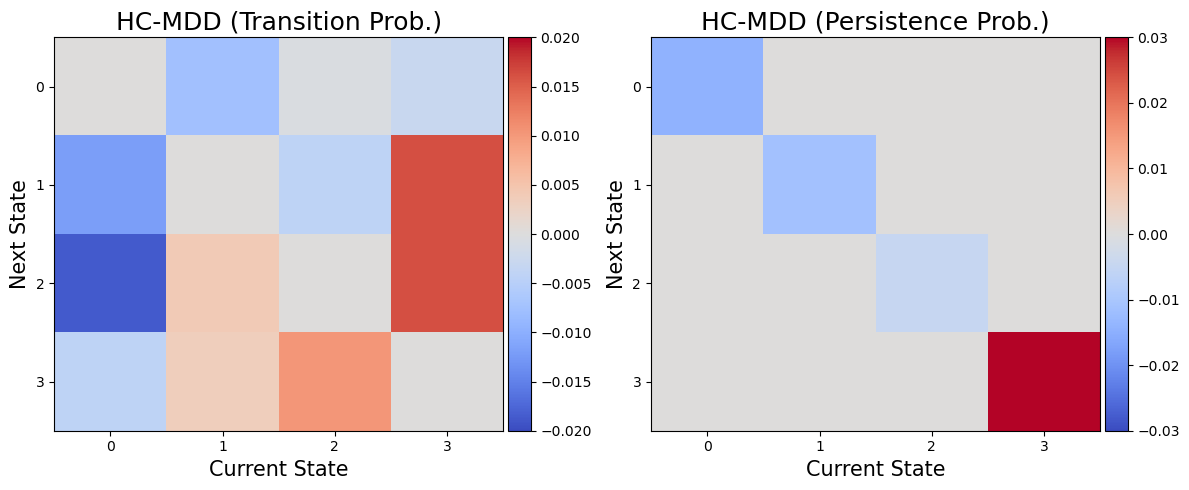

In [21]:
fig,ax = plt.subplots(1,2,figsize = (12,5))
im = ax[0].imshow(transition_hc.mean(axis = 0)-transition_mdd.mean(axis = 0), aspect = 'auto', interpolation = 'none', cmap = 'coolwarm', vmin = -0.02, vmax = 0.02)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax)
ax[0].set_title('HC-MDD (Transition Prob.)', fontsize = 18)
ax[0].set_xticks([k for k in range(K)])
ax[0].set_yticks([k for k in range(K)])
ax[0].set_xlabel('Current State', fontsize = 15)
ax[0].set_ylabel('Next State', fontsize = 15)

im = ax[1].imshow(np.diag(persistence_hc.mean(axis = 0)-persistence_mdd.mean(axis = 0)), aspect = 'auto', interpolation = 'none', cmap = 'coolwarm', vmin = -0.03, vmax = 0.03)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax)
ax[1].set_title('HC-MDD (Persistence Prob.)', fontsize = 18)
ax[1].set_xticks([k for k in range(K)])
ax[1].set_yticks([k for k in range(K)])
ax[1].set_xlabel('Current State', fontsize = 15)
ax[1].set_ylabel('Next State', fontsize = 15)

plt.tight_layout()

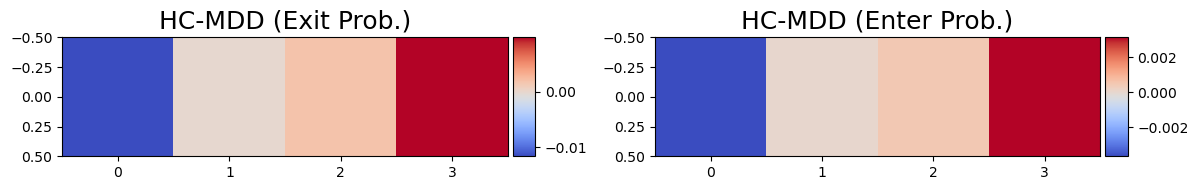

In [22]:
fig,ax = plt.subplots(1,2,figsize = (12,2))
im = ax[0].imshow((transition_hc.mean(axis = 0).sum(axis=0)-transition_mdd.mean(axis = 0).sum(axis=0)).reshape(1,4)/3, aspect = 'auto', interpolation = 'none', cmap = 'coolwarm')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax)
ax[0].set_title('HC-MDD (Exit Prob.)', fontsize = 18)
ax[0].set_xticks([k for k in range(K)])

im = ax[1].imshow((transition_hc.mean(axis = 0).sum(axis=1)-transition_mdd.mean(axis = 0).sum(axis=1)).reshape(1,4)/3, aspect = 'auto', interpolation = 'none', cmap = 'coolwarm')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax)
ax[1].set_title('HC-MDD (Enter Prob.)', fontsize = 18)
ax[1].set_xticks([k for k in range(K)])

plt.tight_layout()

In [23]:
totst_, KS_, ids_, type_, sex_, age_, meds_ = [], [], [], [], [], [], []
st_prob_, st_trans_ = [], []
clnc_mes_, clnc_score_ = [], []
for i, idx in enumerate(healthyID+mddID):
    if idx in healthyID:
        typ = 'HC'
        trnst = transition_hc[i]
    else:
        typ = 'MDD'
        trnst = transition_mdd[int(i-len(healthyID))]
    for score, mes in zip([QIDS,MASQ_aa,MASQ_ad,MASQ_gd, RRS_dr,RRS_b,RRS_r],['QIDS','MASQ_AA','MASQ_AD','MASQ_GD', 'RRS_DR', 'RRS_BR', 'RRS_RF']):
        for x in range(trnst.shape[0]):
            for y in range(trnst.shape[0]):
                if x!=y:
                    ids_.append(idx)
                    type_.append(typ)
                    sex_.append(SEX[idx])
                    age_.append(AGE[idx])
                    meds_.append(MEDS[idx])
                    
                    st_trans_.append('%dto%d'%(x,y))
                    st_prob_.append(trnst[y,x])
                    clnc_mes_.append(mes)
                    clnc_score_.append(score[idx])
            
dfff = pd.DataFrame({'SubjectID':ids_, 'Morbidity':type_, 'Sex':sex_, 'Age':age_, 'Medication':meds_, 'STATETRANS':st_trans_, 'STATEPROB':st_prob_,'CLINICALMES':clnc_mes_, 'CLINICALSCORE':clnc_score_})

In [24]:
dfff

,SubjectID,Morbidity,Sex,Age,Medication,STATETRANS,STATEPROB,CLINICALMES,CLINICALSCORE
0,500,HC,0,39,1,0to1,0.080135,QIDS,20
1,500,HC,0,39,1,0to2,0.057239,QIDS,20
2,500,HC,0,39,1,0to3,0.051515,QIDS,20
3,500,HC,0,39,1,1to0,0.101347,QIDS,20
4,500,HC,0,39,1,1to2,0.123064,QIDS,20
...,...,...,...,...,...,...,...,...,...
1675,609,MDD,0,61,0,2to1,0.105965,RRS_RF,12
1676,609,MDD,0,61,0,2to3,0.084772,RRS_RF,12
1677,609,MDD,0,61,0,3to0,0.072606,RRS_RF,12
1678,609,MDD,0,61,0,3to1,0.087127,RRS_RF,12


<Axes: xlabel='STATETRANS', ylabel='STATEPROB'>

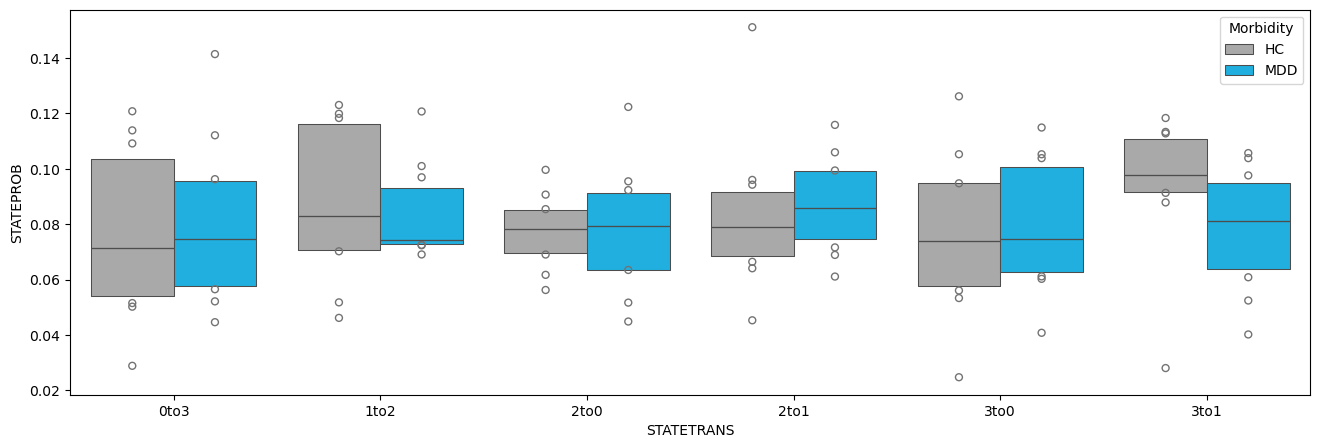

In [25]:
my_pal = {"HC": "darkgrey", "MDD": "deepskyblue"}
st_trans = ['0to3', '3to0', '1to2', '2to1', '2to0', '3to1']
fig,ax = plt.subplots(1,1,figsize = (16,5))
sns.boxenplot(data = dfff[(dfff.STATETRANS.isin(st_trans))&(dfff.CLINICALMES == 'QIDS')], x = 'STATETRANS', y ='STATEPROB', hue = 'Morbidity' ,ax = ax, palette=my_pal)

In [26]:
totst_, KS_, ids_, type_, sex_, age_, meds_ = [], [], [], [], [], [], []
st_prob_, st_trans_ = [], []
clnc_mes_, clnc_score_ = [], []
for i, idx in enumerate(healthyID+mddID):
    if idx in healthyID:
        typ = 'HC'
        trnst = transition_hc[i]
    else:
        typ = 'MDD'
        trnst = transition_mdd[int(i-len(healthyID))]
    for score, mes in zip([QIDS,MASQ_aa,MASQ_ad,MASQ_gd, RRS_dr,RRS_b,RRS_r],['QIDS','MASQ_AA','MASQ_AD','MASQ_GD', 'RRS_DR', 'RRS_BR', 'RRS_RF']):
        for x in range(trnst.shape[0]):
            for tty, transtype in enumerate(['EXIT','ENTER']):
                ids_.append(idx)
                type_.append(typ)
                sex_.append(SEX[idx])
                age_.append(AGE[idx])
                meds_.append(MEDS[idx])
                        
                st_trans_.append('%s %d'%(transtype, x))
                st_prob_.append(trnst.sum(axis=tty)[x]/3)
                clnc_mes_.append(mes)
                clnc_score_.append(score[idx])
            
dfff_total = pd.DataFrame({'SubjectID':ids_, 'Morbidity':type_, 'Sex':sex_, 'Age':age_, 'Medication':meds_, 'STATETRANS':st_trans_, 'STATEPROB':st_prob_, 'CLINICALMES':clnc_mes_, 'CLINICALSCORE':clnc_score_})

<Axes: xlabel='STATETRANS', ylabel='STATEPROB'>

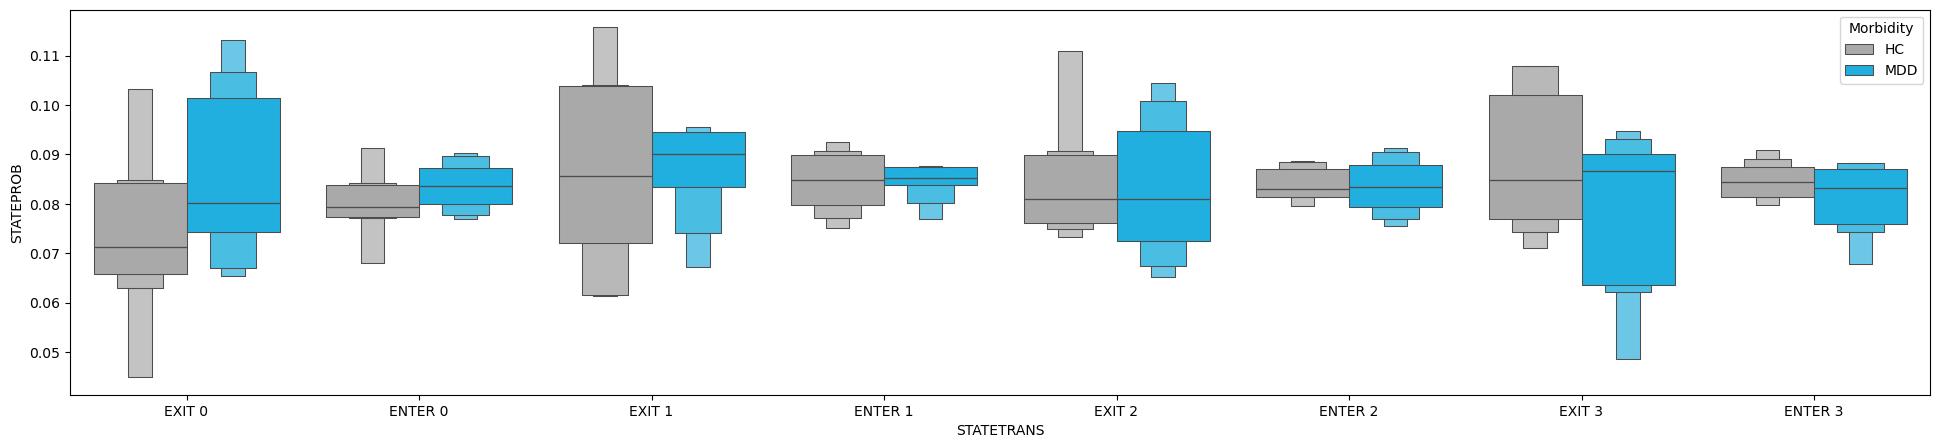

In [27]:
fig,ax = plt.subplots(1,1,figsize = (24,5))
sns.boxenplot(data = dfff_total, x = 'STATETRANS', y ='STATEPROB', hue = 'Morbidity' ,ax = ax, palette=my_pal)

<Axes: xlabel='STATETRANS', ylabel='STATEPROB'>

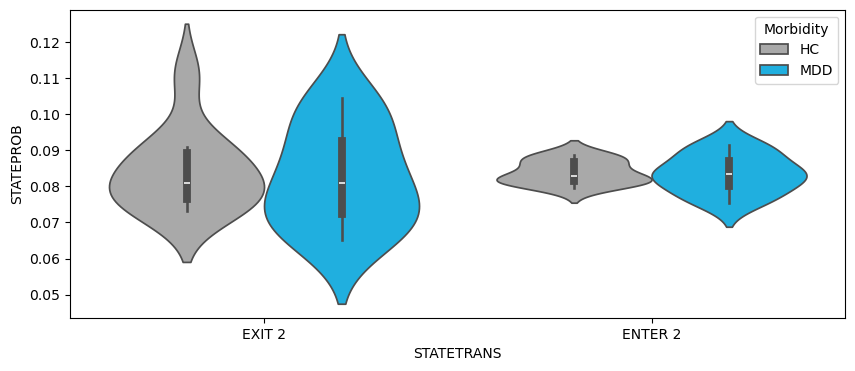

In [28]:
fig,ax = plt.subplots(1,1,figsize = (10,4))
sns.violinplot(data = dfff_total[(dfff_total.STATETRANS.isin(['EXIT 2', 'ENTER 2']))&(dfff_total.CLINICALMES=='QIDS')], x = 'STATETRANS', y ='STATEPROB', hue = 'Morbidity' ,ax = ax, palette=my_pal, density_norm='width')

                            OLS Regression Results                            
Dep. Variable:              DWELLTIME   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                 -0.059
Method:                 Least Squares   F-statistic:                    0.8743
Date:                Thu, 14 Aug 2025   Prob (F-statistic):              0.539
Time:                        15:03:01   Log-Likelihood:                 1.4331
No. Observations:                  10   AIC:                             7.134
Df Residuals:                       5   BIC:                             8.647
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3366      0.368     14.482      0.0

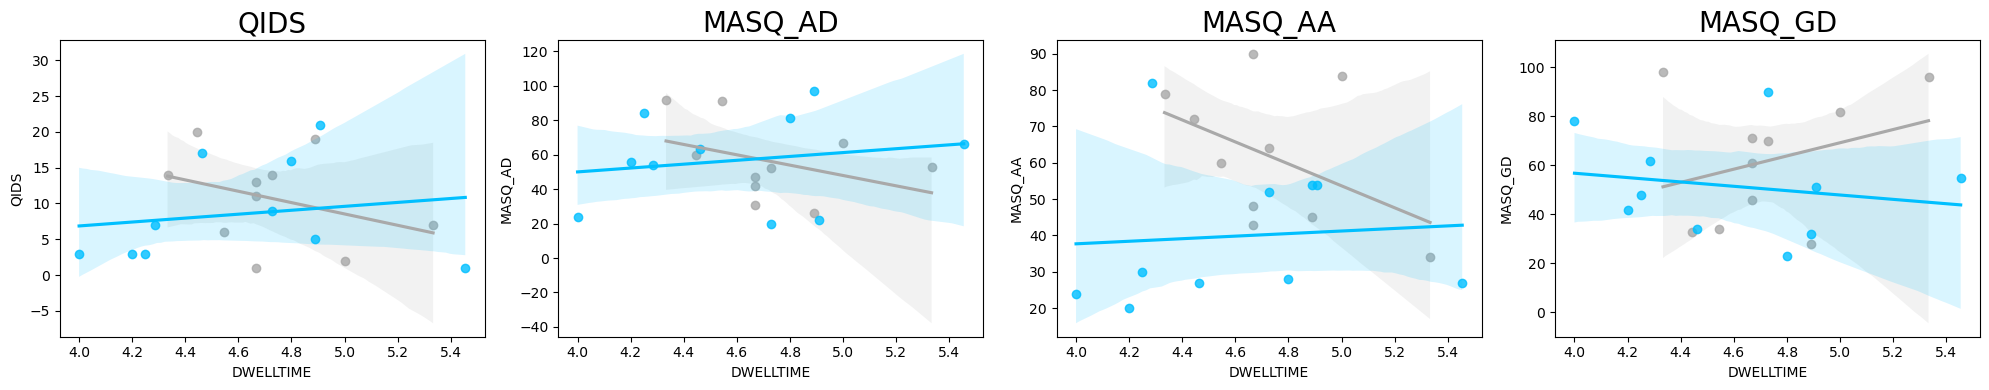

In [29]:
K = 4
it  = np.argmax([inertias[K,it] for it in range(niter)])
k=2
my_pal = {"HC": "darkgrey", "MDD": "deepskyblue"}
pvalshc = []
pvalsmdd = []
fig, ax = plt.subplots(1,4, figsize = (20,4))
for i, mes in enumerate(['QIDS','MASQ_AD', 'MASQ_AA', 'MASQ_GD']):
    data = df[(df.totalstates == K)&(df.StateID == k)&(df.Morbidity=='HC')]
    im = sns.regplot(data=data, x = 'DWELLTIME', y= "%s"%mes, ax = ax[i], label= 'HC', color = "darkgrey")
    mask = ~np.isnan(data['DWELLTIME'].to_numpy()) & ~np.isnan(data['%s'%mes].to_numpy())
    X = data[['%s'%mes, 'Sex', 'Age', 'Medication']][mask]
    X = sm.add_constant(X)
    y = data['DWELLTIME'][mask]
    model = sm.OLS(y, X).fit()
    print(model.summary())
    pvalshc.append(model.pvalues.iloc[1])
    
    data = df[(df.totalstates == K)&(df.StateID == k)&(df.Morbidity=='MDD')]
    im = sns.regplot(data=data, x = 'DWELLTIME', y= "%s"%mes, ax = ax[i], label= 'MDD',color = "deepskyblue")        
    mask = ~np.isnan(data['DWELLTIME'].to_numpy()) & ~np.isnan(data['%s'%mes].to_numpy())
    X = data[['%s'%mes, 'Sex', 'Age', 'Medication']][mask]
    X = sm.add_constant(X)
    y = data['DWELLTIME'][mask]
    model = sm.OLS(y, X).fit()
    print(model.summary())
    pvalsmdd.append(model.pvalues.iloc[1])
    ax[i].set_title(mes, fontsize = 20)

plt.tight_layout()

In [30]:
fdrcorrection(pvalsmdd)

(array([False, False, False, False]),
 array([0.92777759, 0.99278853, 0.92777759, 0.92777759]))

                            OLS Regression Results                            
Dep. Variable:              STATEPROB   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     6.266
Date:                Thu, 14 Aug 2025   Prob (F-statistic):             0.0348
Time:                        15:03:01   Log-Likelihood:                 32.752
No. Observations:                  10   AIC:                            -55.50
Df Residuals:                       5   BIC:                            -53.99
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1648      0.025      6.516

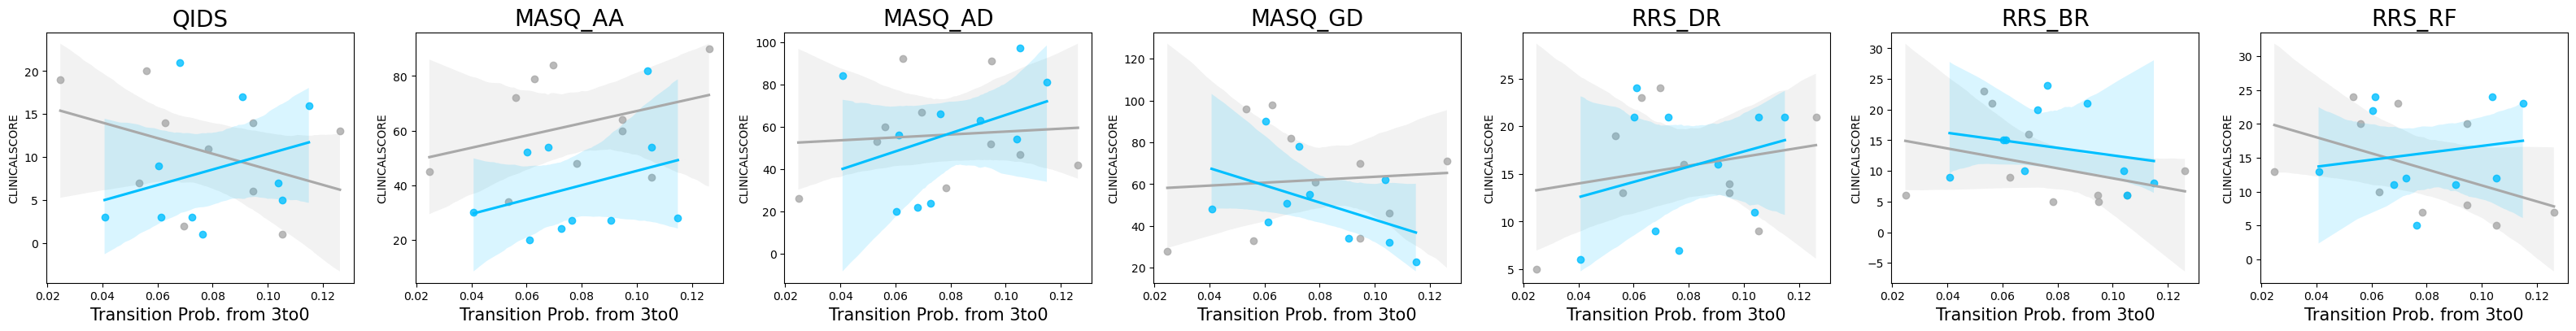

In [31]:
pvalshc = []
pvalsmdd = []

st_trans = '3to0'

K = 4
it  = np.argmax([inertias[K,it] for it in range(niter)])
fig,ax = plt.subplots(1,7,figsize = (40,4))
for i, mes in enumerate(clinical_measures):
    data = dfff[(dfff['Morbidity']=="HC")&(dfff['CLINICALMES']==mes)&(dfff['STATETRANS']==st_trans)]
    im = sns.regplot(data=data, x = 'STATEPROB', y= 'CLINICALSCORE', ax = ax[i], label= 'HC', color = "darkgrey")
    mask = ~np.isnan(data['STATEPROB'].to_numpy()) & ~np.isnan(data['CLINICALSCORE'].to_numpy())
    X = data[['CLINICALSCORE', 'Sex', 'Age', 'Medication']][mask]
    X = sm.add_constant(X)
    y = data['STATEPROB'][mask]
    model = sm.OLS(y, X).fit()
    pvalshc.append(model.pvalues.iloc[1])

    
    data = dfff[(dfff['Morbidity']=="MDD")&(dfff['CLINICALMES']==mes)&(dfff['STATETRANS']==st_trans)]
    im = sns.regplot(data=data, x = 'STATEPROB', y= 'CLINICALSCORE', ax = ax[i], label= 'MDD', color = "deepskyblue")
    mask = ~np.isnan(data['STATEPROB'].to_numpy()) & ~np.isnan(data['CLINICALSCORE'].to_numpy())
    X = data[['CLINICALSCORE', 'Sex', 'Age', 'Medication']][mask]
    X = sm.add_constant(X)
    y = data['STATEPROB'][mask]
    model = sm.OLS(y, X).fit()
    pvalsmdd.append(model.pvalues.iloc[1])
    
    ax[i].set_title(mes, fontsize = 20)
    ax[i].set_xlabel('Transition Prob. from %s'%st_trans, fontsize = 15)
    
    print(model.summary())

In [32]:
fdrcorrection(pvalshc),pvalshc

((array([False, False, False, False, False, False, False]),
  array([0.64635438, 0.64635438, 0.54582812, 0.89925291, 0.99137171,
         0.49857258, 0.64635438])),
 [0.46168169752576627,
  0.2778917982648959,
  0.1559508915242059,
  0.7707882061705617,
  0.9913717128158214,
  0.07122465431469632,
  0.38861519324597815])

## Network Control Theory

In [34]:
np.random.seed(42)  # reproducibility

# Generate adjacency matrices for healthy subjects
healthyDTI = {f"{500+i}": random_adjacency(size) for i in range(n_healthy)}

# Generate adjacency matrices for MDD subjects
mddDTI = {f"{600+i}": random_adjacency(size) for i in range(n_mdd)}

allDTI = all_adj = {**healthyDTI, **mddDTI}

In [35]:
K=4
it  = np.argmax([inertias[K,it] for it in range(niter)])
norm_states = {}
for k in range(K):
    norm_states[k] = normalize_state(medoids[K,it][k])

totalenergies, node_energies, state_trajectory, control_signals, totalenergies_pers, node_energies_pers, state_trajectory_pers, control_signals_pers  = NCT_multi(healthyID, mddID, allDTI, norm_states, K, size)

In [36]:
ids_, type_, sex_, age_, meds_ = [], [], [], [], []
roi_, st_trans_, ne_= [], [], []
clnc_mes_, clnc_score_ = [], []

for idx in healthyID+mddID:
    if idx in healthyID: group = 'HC'
    elif idx in mddID: group = 'MDD'

    for score, mes in zip([QIDS, MASQ_aa, MASQ_ad, MASQ_gd, RRS_dr, RRS_b, RRS_r],['QIDS', 'MASQ_AA', 'MASQ_AD', 'MASQ_GD', 'RRS_DR', 'RRS_BR', 'RRS_RF']):
        for k1 in range(K):
            for k2 in range(K):
                if k1 != k2:
                    for n in range(size):
                        ids_.append(idx)
                        sex_.append(SEX[idx])
                        age_.append(AGE[idx])
                        meds_.append(MEDS[idx])
                                
                        type_.append(group)
                        st_trans_.append('%dto%d'%(k1,k2))
                        roi_.append(n)
                        ne_.append(node_energies[idx][k2,k1,n])
                                
                        clnc_mes_.append(mes)
                        clnc_score_.append(score[idx])
                else:
                    for n in range(size):
                        ids_.append(idx)
                        sex_.append(SEX[idx])
                        age_.append(AGE[idx])
                        meds_.append(MEDS[idx])
                                
                        type_.append(group)
                        st_trans_.append('%dto%d'%(k1,k2))
                        roi_.append(n)
                        ne_.append(node_energies_pers[idx][k2,k1,n])
                                
                        clnc_mes_.append(mes)
                        clnc_score_.append(score[idx])
                    
            for t, total in enumerate(['EXIT', 'ENTER']):
                for n in range(size):
                    ids_.append(idx)
                    sex_.append(SEX[idx])
                    age_.append(AGE[idx])
                    meds_.append(MEDS[idx])
                                
                    type_.append(group)
                    st_trans_.append('%s%d'%(total,k1))
                    roi_.append(n)
                    ne_.append(node_energies[idx].sum(axis = t)[k1,n]/3)

                    clnc_mes_.append(mes)
                    clnc_score_.append(score[idx])


dfff_nct = pd.DataFrame({'SubjectID':ids_, 'Morbidity':type_, 'Sex':sex_, 'Age':age_, 'Medication':meds_,
                         'STATETRANS':st_trans_, 'ROI':roi_, 'NODEENERGIES':ne_, 
                         'CLINICALMES':clnc_mes_, 'CLINICALSCORE':clnc_score_})

In [37]:
dfff_nct

,SubjectID,Morbidity,Sex,Age,Medication,STATETRANS,ROI,NODEENERGIES,CLINICALMES,CLINICALSCORE
0,500,HC,0,39,1,0to0,0,28.227411,QIDS,20
1,500,HC,0,39,1,0to0,1,6.114918,QIDS,20
2,500,HC,0,39,1,0to0,2,1.456987,QIDS,20
3,500,HC,0,39,1,0to0,3,2.577041,QIDS,20
4,500,HC,0,39,1,0to0,4,3.542247,QIDS,20
...,...,...,...,...,...,...,...,...,...,...
285595,609,MDD,0,61,0,ENTER3,80,1.444277,RRS_RF,12
285596,609,MDD,0,61,0,ENTER3,81,137.442513,RRS_RF,12
285597,609,MDD,0,61,0,ENTER3,82,18.425832,RRS_RF,12
285598,609,MDD,0,61,0,ENTER3,83,76.249451,RRS_RF,12


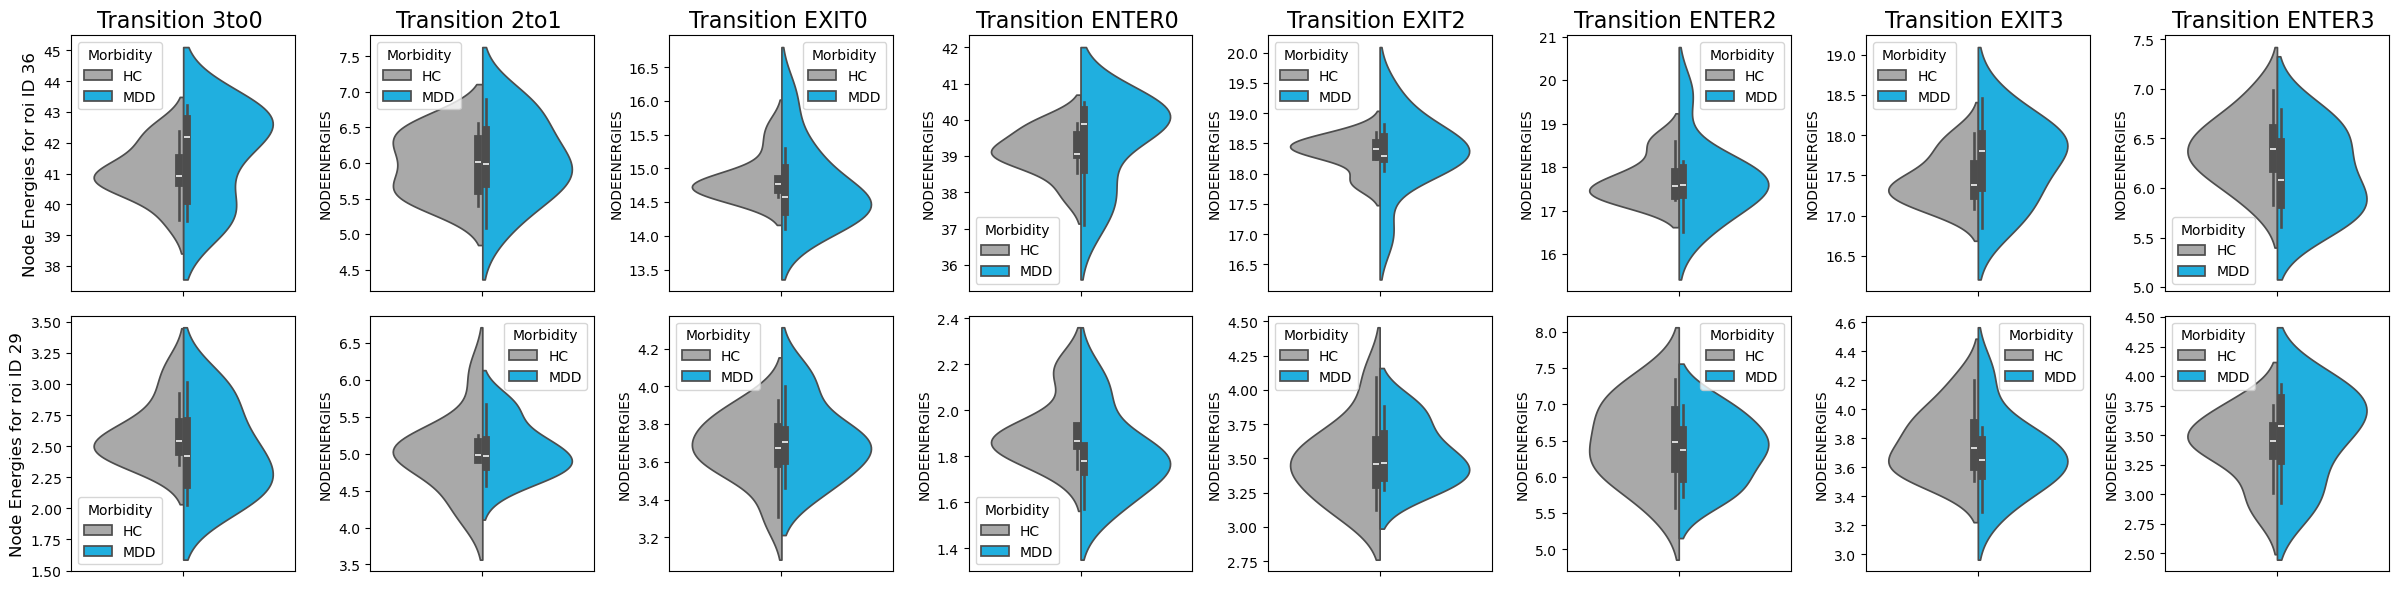

In [38]:
ROIs = [np.random.randint(40) for _ in range(2)]

fig, ax = plt.subplots(2,8, figsize=(24,6))
for s,st_trans in enumerate(['3to0', '2to1', 'EXIT0', 'ENTER0', 'EXIT2', 'ENTER2', 'EXIT3', 'ENTER3']):
    for n,roi in enumerate(ROIs): 
        sns.violinplot(data = dfff_nct[(dfff_nct.ROI == roi)&(dfff_nct.CLINICALMES=='QIDS')&(dfff_nct.STATETRANS == st_trans)], y = 'NODEENERGIES', ax = ax[n][s], hue = 'Morbidity', palette=my_pal, split = True)
        ax[0][s].set_title(f"Transition %s "%st_trans, fontsize = 16)
        ax[n][s].tick_params(axis='both', which='major', labelsize=10)
        ax[n][0].set_ylabel('Node Energies for roi ID %d'%roi, fontsize = 12)
plt.tight_layout()

In [39]:
ids_, type_, sex_, age_, meds_ = [], [], [], [], []
st_trans_, te_, tp_, = [], [], []
clnc_mes_, clnc_score_ = [], []
for idx in healthyID+mddID:

    if idx in healthyID: group = 'HC'
    elif idx in mddID: group = 'MDD'

    for score, mes in zip([QIDS, MASQ_aa, MASQ_ad, MASQ_gd],['QIDS', 'MASQ_AA', 'MASQ_AD', 'MASQ_GD']):
        for k1 in range(K):
            for k2 in range(K):
                if k1 != k2:
                    ids_.append(idx)
                    sex_.append(SEX[idx])
                    age_.append(AGE[idx])
                    meds_.append(MEDS[idx])
                                
                    type_.append(group)
                    st_trans_.append('%dto%d'%(k1,k2))
                    te_.append(totalenergies[idx][k2,k1])
                    tp_.append(transition_probs[idx][k2,k1])
                                
                    clnc_mes_.append(mes)
                    clnc_score_.append(score[idx])
                else:
                    ids_.append(idx)
                    sex_.append(SEX[idx])
                    age_.append(AGE[idx])
                    meds_.append(MEDS[idx])
                                
                    type_.append(group)
                    st_trans_.append('%dto%d'%(k1,k2))
                    te_.append(totalenergies_pers[idx][k2,k1])
                    tp_.append(persistence_probs[idx][k1])
                                
                    clnc_mes_.append(mes)
                    clnc_score_.append(score[idx])

        for k1 in range(K):
            for t, total in enumerate(['EXIT', 'ENTER']):
                ids_.append(idx)
                sex_.append(SEX[idx])
                age_.append(AGE[idx])
                meds_.append(MEDS[idx])
                                
                type_.append(group)
                st_trans_.append('%s%d'%(total,k1))
                te_.append(totalenergies[idx].sum(axis=t)[k1]/3)
                tp_.append(transition_probs[idx].sum(axis=t)[k1]/3)
                                
                clnc_mes_.append(mes)
                clnc_score_.append(score[idx])

dfff_energies = pd.DataFrame({'SubjectID':ids_, 'Morbidity':type_, 'Sex':sex_, 'Age':age_, 'Medication':meds_,
                              'STATETRANS':st_trans_, 'STATEENERGY':te_, 'STATEPROB':tp_, 
                              'CLINICALMES':clnc_mes_, 'CLINICALSCORE':clnc_score_})

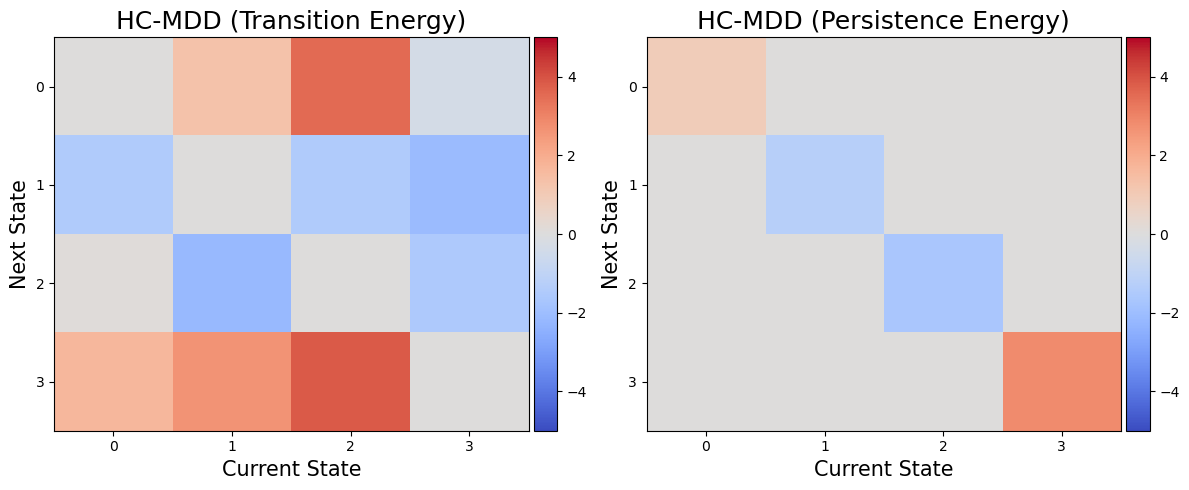

In [40]:
fig,ax = plt.subplots(1,2,figsize = (12,5))

arrhc = np.array([totalenergies[idx] for idx in healthyID])
arrmdd = np.array([totalenergies[idx] for idx in mddID])

im = ax[0].imshow(arrhc.mean(axis = 0) - arrmdd.mean(axis = 0), aspect = 'auto', interpolation = 'none', cmap = 'coolwarm', vmin = -5, vmax = 5)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax)
ax[0].set_title('HC-MDD (Transition Energy)', fontsize = 18)
ax[0].set_xticks([k for k in range(K)])
ax[0].set_yticks([k for k in range(K)])
ax[0].set_xlabel('Current State', fontsize = 15)
ax[0].set_ylabel('Next State', fontsize = 15)

arrhc_pers = np.array([totalenergies_pers[idx] for idx in healthyID])
arrmdd_pers = np.array([totalenergies_pers[idx] for idx in mddID])

im = ax[1].imshow(arrhc_pers.mean(axis = 0) - arrmdd_pers.mean(axis = 0), aspect = 'auto', interpolation = 'none', cmap = 'coolwarm', vmin = -5, vmax = 5)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax)
ax[1].set_title('HC-MDD (Persistence Energy)', fontsize = 18)
ax[1].set_xticks([k for k in range(K)])
ax[1].set_yticks([k for k in range(K)])
ax[1].set_xlabel('Current State', fontsize = 15)
ax[1].set_ylabel('Next State', fontsize = 15)

plt.tight_layout()

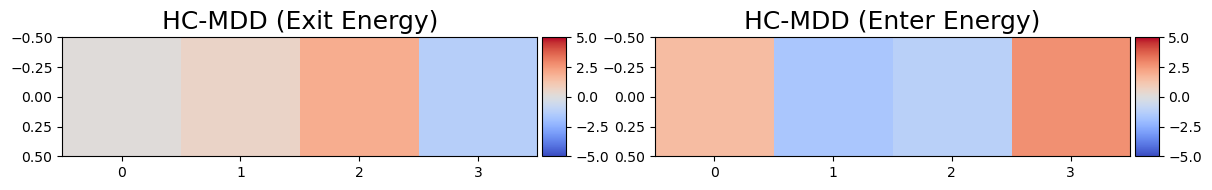

In [41]:
fig,ax = plt.subplots(1,2,figsize = (12,2))
arrhc = np.array([totalenergies[idx] for idx in healthyID])
arrmdd = np.array([totalenergies[idx] for idx in mddID])

im = ax[0].imshow((arrhc.mean(axis = 0).sum(axis=0)/3 - arrmdd.mean(axis = 0).sum(axis=0)/3).reshape(1,4), aspect = 'auto', interpolation = 'none', cmap = 'coolwarm', vmin = -5, vmax = 5)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax)
ax[0].set_title('HC-MDD (Exit Energy)', fontsize = 18)
ax[0].set_xticks([k for k in range(K)])

im = ax[1].imshow((arrhc.mean(axis = 0).sum(axis=1)/3 - arrmdd.mean(axis = 0).sum(axis=1)/3).reshape(1,4), aspect = 'auto', interpolation = 'none', cmap = 'coolwarm', vmin = -5, vmax = 5)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax)
ax[1].set_title('HC-MDD (Enter Energy)', fontsize = 18)
ax[1].set_xticks([k for k in range(K)])

plt.tight_layout()

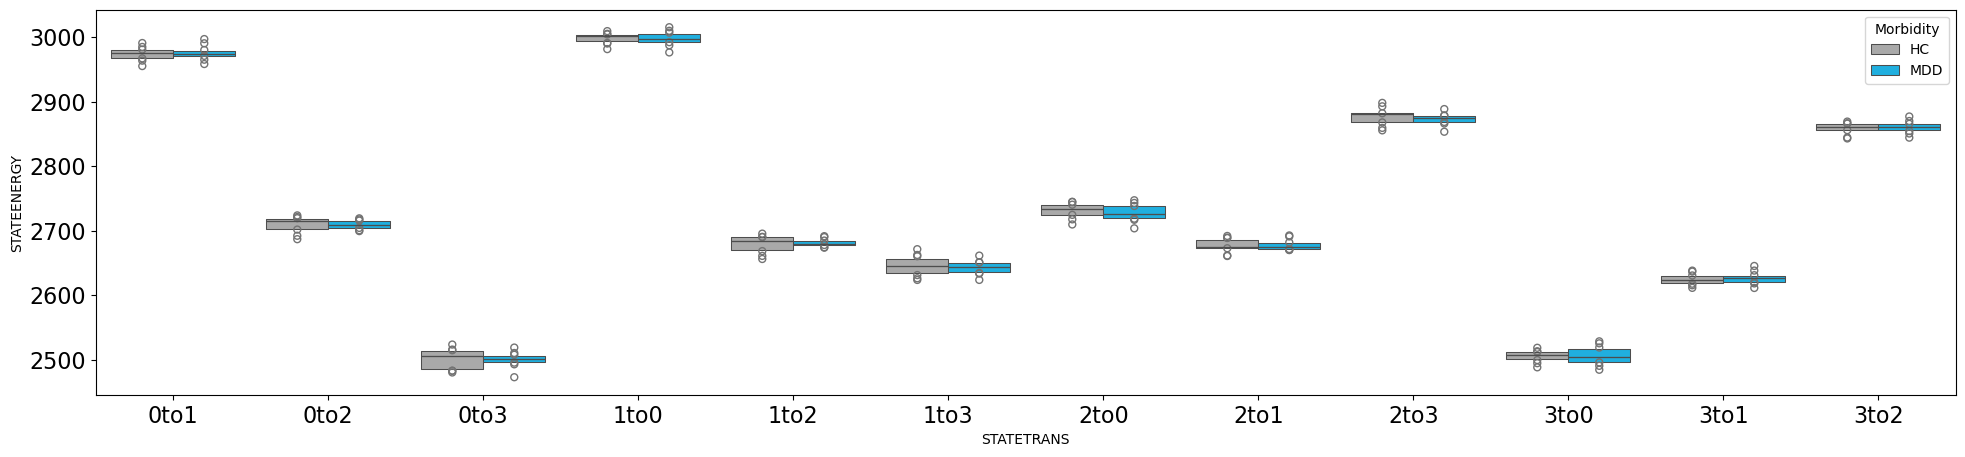

In [42]:
st_trans = ['0to1','0to2', '0to3', '1to2', '2to1', '2to0', '0to2', '1to3', '3to1', '1to0', '0to1', '3to0','3to2', '2to3']
my_pal = {"HC": "darkgrey", "MDD": "deepskyblue"}
fig,ax = plt.subplots(1,1,figsize= (24,5))
sns.boxenplot(data = dfff_energies[(dfff_energies.STATETRANS.isin(st_trans))&(dfff_energies.CLINICALMES =='QIDS')], x = 'STATETRANS', y ='STATEENERGY', ax = ax, hue = 'Morbidity', palette=my_pal)
ax.tick_params(axis='both', which='major', labelsize=16)

<Axes: xlabel='STATETRANS', ylabel='STATEENERGY'>

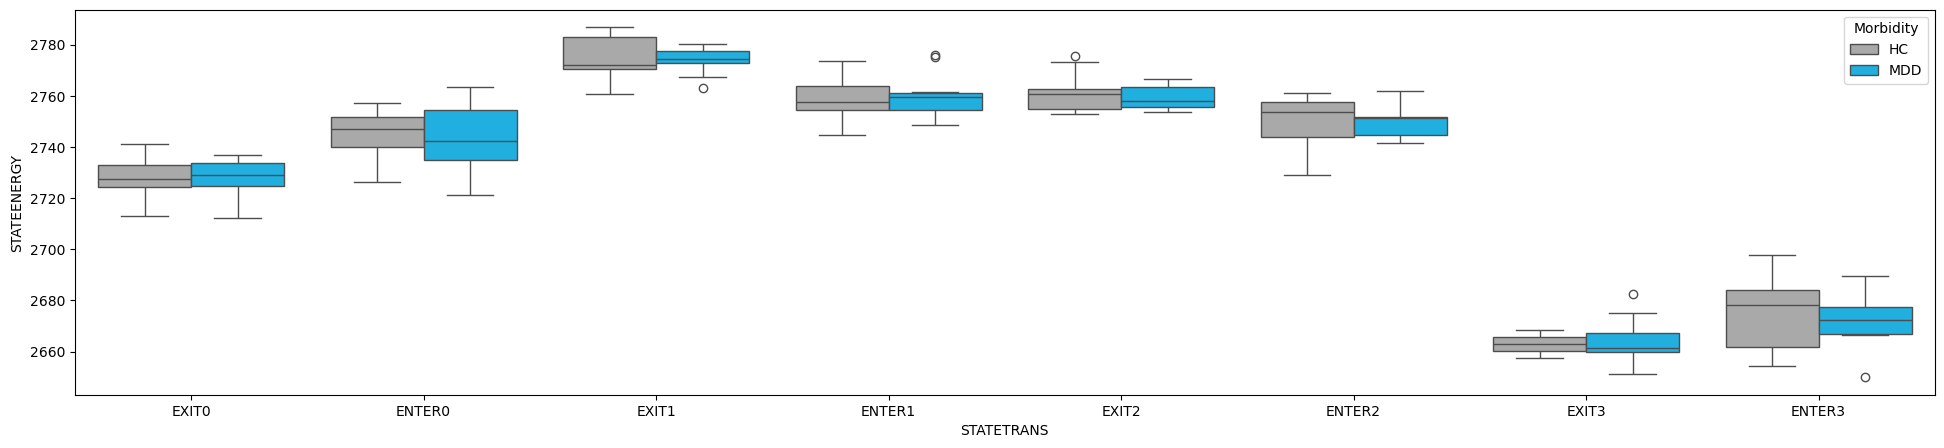

In [43]:
my_pal = {"HC": "darkgrey", "MDD": "deepskyblue"} 

st_trans1 = ['EXIT0', 'EXIT1', 'EXIT2', 'EXIT3','ENTER0','ENTER1', 'ENTER2','ENTER3']
fig,ax = plt.subplots(1,1,figsize= (24,5))
sns.boxplot(data = dfff_energies[(dfff_energies.STATETRANS.isin(st_trans1))&(dfff_energies.CLINICALMES =='QIDS')], x = 'STATETRANS', y ='STATEENERGY', ax = ax, palette=my_pal, hue = 'Morbidity')

0
-16.015594348558352
TtestResult(statistic=-4.463042229057783, pvalue=0.0002666433817080753, df=19)
1
14.857049602508141
TtestResult(statistic=4.880928117805969, pvalue=0.00010377705708255967, df=19)
2
10.60765999783871
TtestResult(statistic=3.752595238541036, pvalue=0.0013479746127187718, df=19)
3
-9.449115251787589
TtestResult(statistic=-2.7127238344663183, pvalue=0.013804859027074724, df=19)


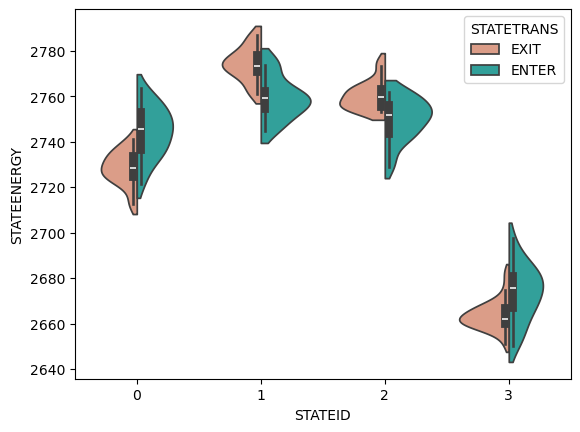

In [44]:
ids_, type_ = [], []
st_trans_, te_, states_  = [], [], []
for idx in healthyID+mddID:

    if idx in healthyID: group = 'HC'
    elif idx in mddID: group = 'MDD'
    else: print('WTF')

    for k1 in range(K):
        for t, total in enumerate(['EXIT', 'ENTER']):
            ids_.append(idx)
                                
            type_.append(group)
            states_.append(k1)
            st_trans_.append('%s'%(total))
            te_.append(totalenergies[idx].sum(axis=t)[k1]/3)
                            

dfff_energies_exitenter = pd.DataFrame({'SubjectID':ids_, 'Morbidity':type_, 'STATEID':states_, 'STATETRANS':st_trans_, 'STATEENERGY':te_})
my_pal23 = {"EXIT": "darksalmon", "ENTER": "lightseagreen"}
sns.violinplot(data = dfff_energies_exitenter, x = 'STATEID', y ='STATEENERGY', palette=my_pal23, hue = 'STATETRANS', cut = True, split = True, density_norm='area')
st_trans = ['EXIT%d', 'ENTER%d']
for k in range(4):
    print(k)
    print(dfff_energies[(dfff_energies.STATETRANS == 'EXIT%d'%k)&(dfff_energies.CLINICALMES =='QIDS')].STATEENERGY.to_numpy().mean()-dfff_energies[(dfff_energies.STATETRANS == 'ENTER%d'%k)&(dfff_energies.CLINICALMES =='QIDS')].STATEENERGY.to_numpy().mean())
    print(ttest_rel(dfff_energies[(dfff_energies.STATETRANS == 'EXIT%d'%k)&(dfff_energies.CLINICALMES =='QIDS')].STATEENERGY.to_numpy(),dfff_energies[(dfff_energies.STATETRANS == 'ENTER%d'%k)&(dfff_energies.CLINICALMES =='QIDS')].STATEENERGY.to_numpy()))

                            OLS Regression Results                            
Dep. Variable:              STATEPROB   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.6627
Date:                Thu, 14 Aug 2025   Prob (F-statistic):              0.439
Time:                        15:03:13   Log-Likelihood:                 21.967
No. Observations:                  10   AIC:                            -39.93
Df Residuals:                       8   BIC:                            -39.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.1592      2.747     -0.786      

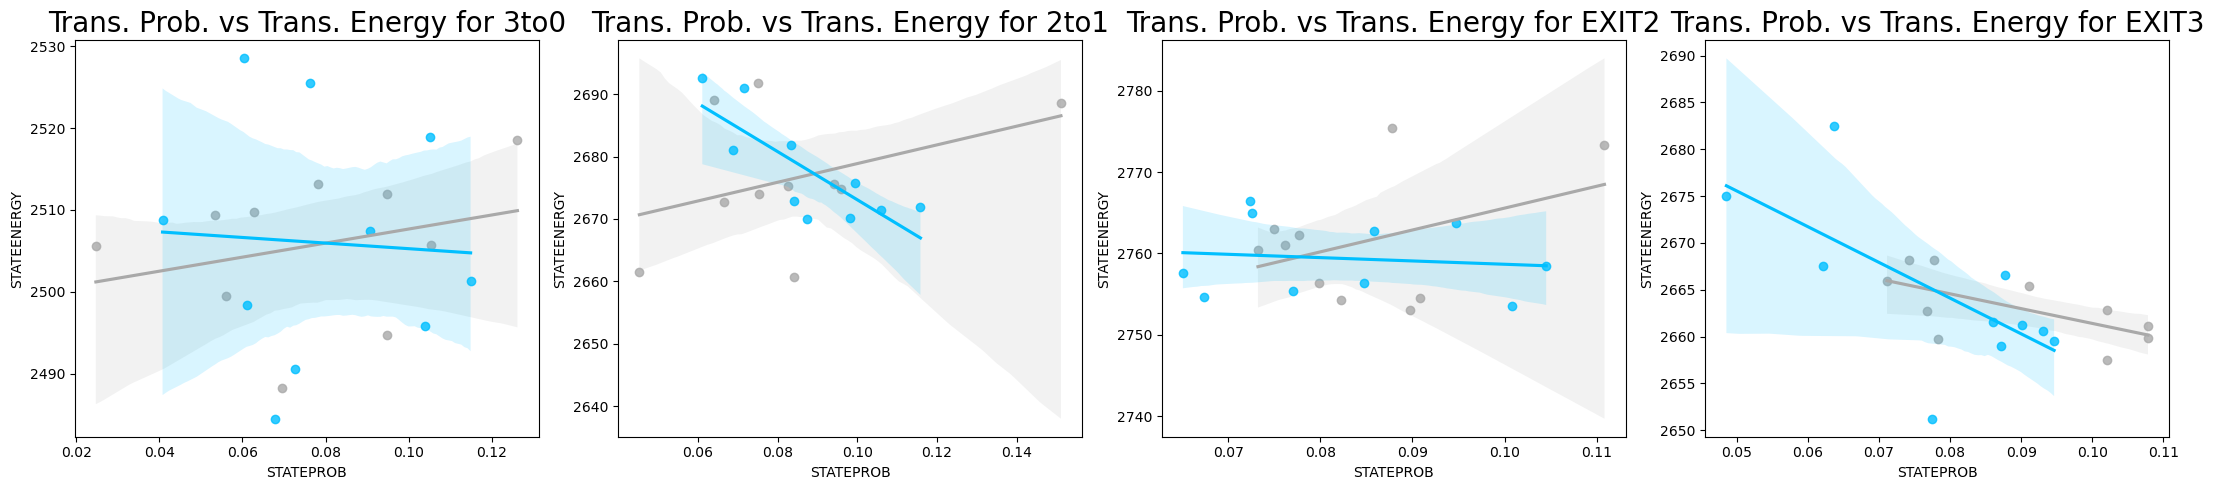

In [45]:
my_pal = {"HC": "darkgrey", "MDD": "deepskyblue"}
fig,ax = plt.subplots(1,4,figsize = (22,5))
for st, st_trans in enumerate(['3to0', '2to1', 'EXIT2', "EXIT3"]):
    ax[st].set_title('%s'%st_trans, fontsize = 16)
    for group in ['HC', 'MDD']:
        data = dfff_energies[(dfff_energies.STATETRANS == st_trans)&(dfff_energies.CLINICALMES == 'QIDS')&(dfff_energies.Morbidity == group)]
        im = sns.regplot(data=data, x = 'STATEPROB', y = 'STATEENERGY', ax = ax[st],  label= group,  color = my_pal[group])
        X = data[['STATEENERGY']]
        X = sm.add_constant(X)
        y = data['STATEPROB']
        linear_model = sm.OLS(y, X).fit()
        print(linear_model.summary())
        ax[st].set_title('Trans. Prob. vs Trans. Energy for %s'%(st_trans), fontsize = 20)
plt.tight_layout()